In [1]:
#코랩 GPU확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [38]:
import os #파일경로 불러오기용
import cv2 #이미지 처리용
import pandas as pd #데이터 프레임 조작용

In [39]:
def create_df(data_path):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        img_path_list.append(img_path)
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [40]:
df = create_df('natural_images')

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
airplane 727
car 968
cat 885
dog 702
flower 843
fruit 1000
motorbike 788
person 986


In [41]:
display(df)

File_path   Label
0     natural_images/person/person_0708.jpg  person
1           natural_images/dog/dog_0120.jpg     dog
2           natural_images/cat/cat_0613.jpg     cat
3       natural_images/fruit/fruit_0759.jpg   fruit
4           natural_images/dog/dog_0189.jpg     dog
...                                     ...     ...
6894    natural_images/fruit/fruit_0806.jpg   fruit
6895        natural_images/dog/dog_0684.jpg     dog
6896        natural_images/car/car_0926.jpg     car
6897        natural_images/dog/dog_0027.jpg     dog
6898        natural_images/dog/dog_0152.jpg     dog

[6899 rows x 2 columns]

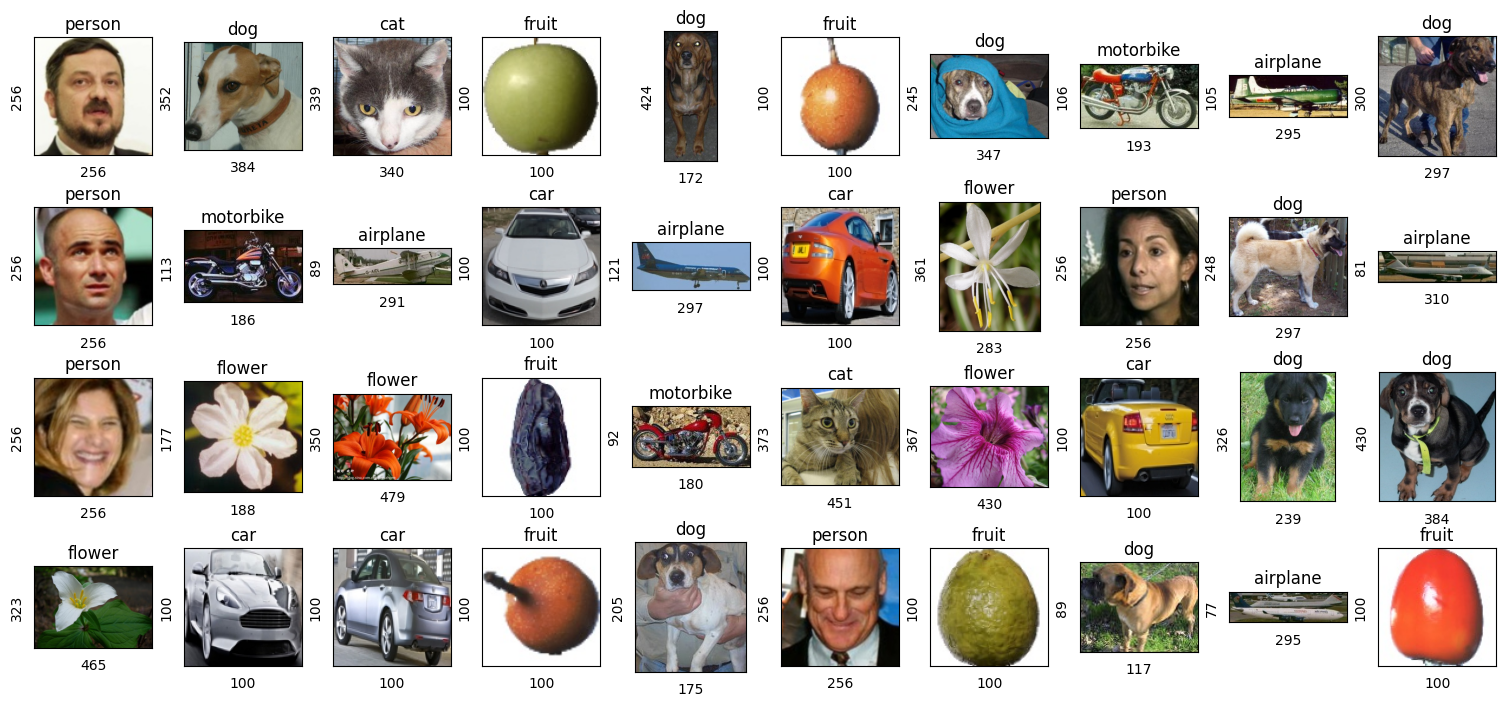

In [42]:
import matplotlib.pyplot as plt
"""
  데이터 확인(이미지 라벨, 가로크기,세로크기)
"""
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.File_path[i]))
    img = cv2.imread(df.File_path[i])
    ax.set_title(df.Label[i], fontsize = 12)
    ax.set_xlabel(img.shape[1], fontsize=10)
    ax.set_ylabel(img.shape[0], fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
"""
  훈련데이터,테스트데이터로 나누기, 9:1, 계층샘플링적용
"""
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0,stratify=df.Label)
train_df.shape,test_df.shape

((6209, 2), (690, 2))

In [53]:
import numpy as np
"""
  150x150로 이미지 전처리, 32개 묶음 배치 생성
"""
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')


Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [54]:
#2층 CNN모델
#GPU훈련
with tf.device('/device:GPU:0'):
  # 시퀀셜모델(레이어모델) 생성
  cnn = tf.keras.models.Sequential()

  # 1층 convolution&pooling
  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  # 2층 convolution&pooling
  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  # 3층 convolution 레이어에서 나온 특징 평탄화
  cnn.add(tf.keras.layers.Flatten())

  # 4층 완전연결신경망
  cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

  # 5층 Softmax분류결과출력 신경망
  cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

  # compile,adam,categorical_crossentropy
  cnn.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
  cnn.summary()

  #에포크 10 훈련
  history = cnn.fit(train_gen, 
                    epochs=10,
                    validation_data=val_gen)



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 41472)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [55]:
#모델 저장
cnn.save('baseline_cnn.h5')

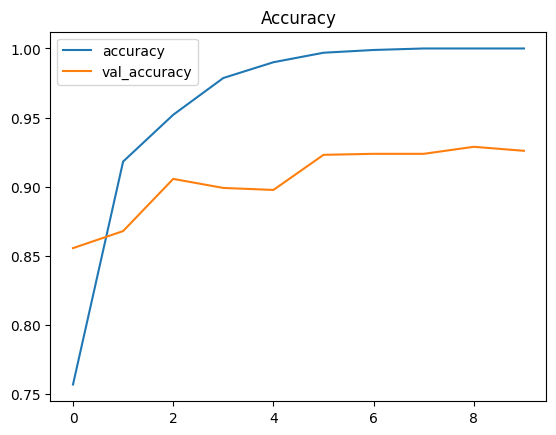

In [56]:
#정확도그래프
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

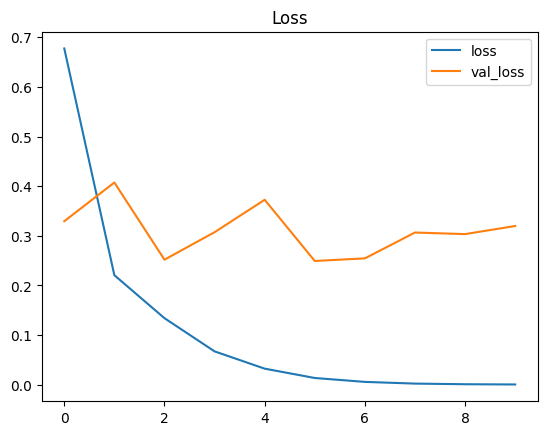

In [57]:
#오차그래프
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

번호 입력 :  50


'예측률 : 100.00%'

'클래스 = cat'

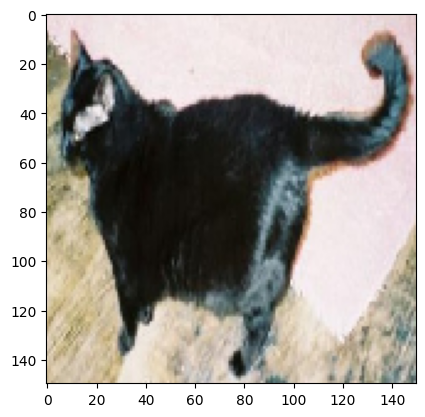

In [59]:
#모델 로드 후 개별 이미지 예측 테스트
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
def printmd(string):
    display(string)
class_dictionary = {'airplane': 0,
                    'car': 1,
                    'cat': 2,
                    'dog': 3,
                    'flower': 4,
                    'fruit': 5,
                    'motorbike': 6,
                    'person': 7}

model = load_model('baseline_cnn.h5')
IMAGE_SIZE    = (150, 150)
number_1 = int(input("번호 입력 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"클래스 = {x}")
    break

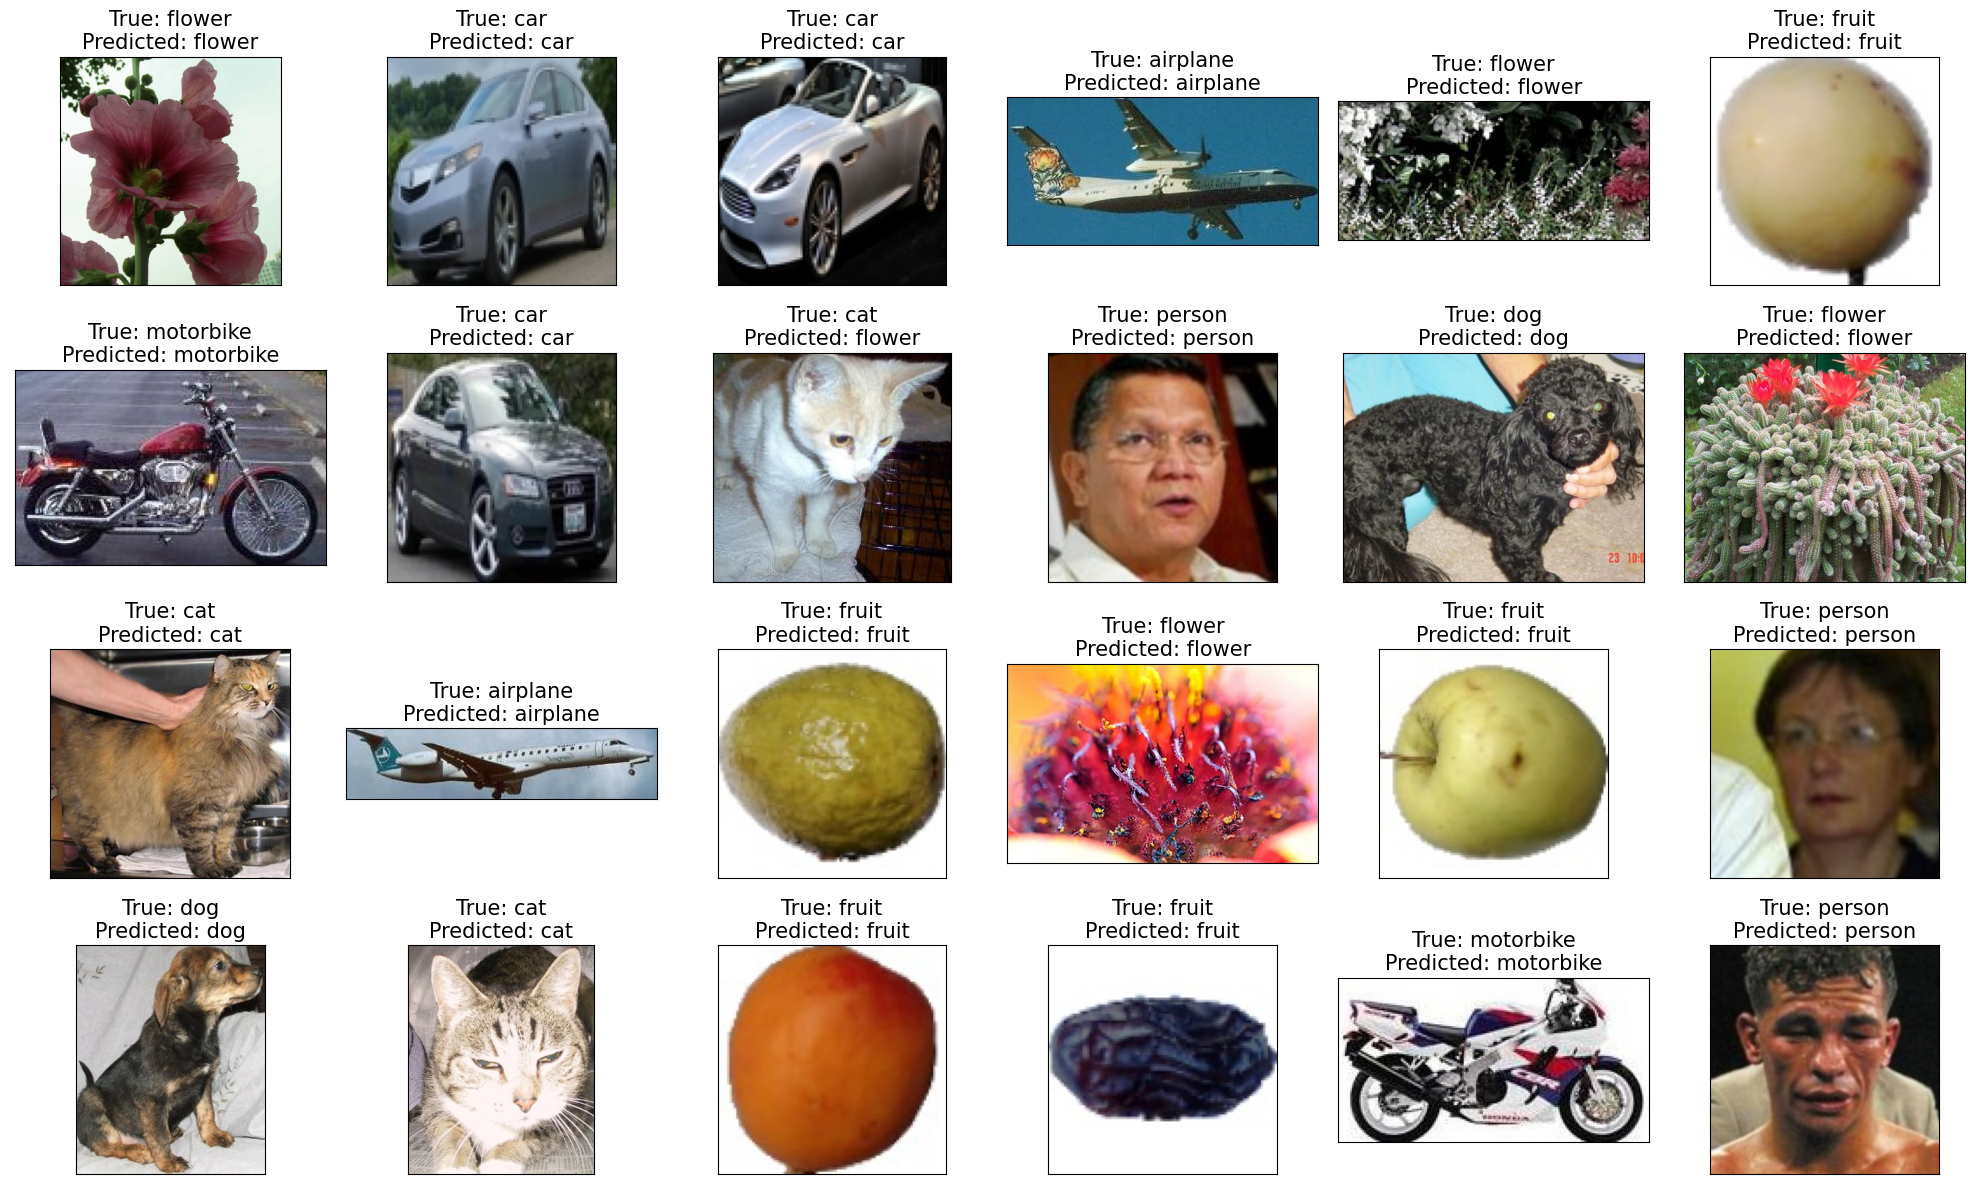

In [60]:
#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()